In [1]:
import pandas as pd
import numpy as np
import cv2
import os
import shutil
from PIL import Image as img
import torch
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time


In [2]:
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is not available.  Training on CPU ...


In [3]:
print(os.listdir("../CatsvsDogscode"))
path = "../CatsvsDogscode/dogs-vs-cats/train/"
print(os.listdir(path))


['.git', '.ipynb_checkpoints', '11T.4A188jojJiyhHVBFZZlg.jpeg', 'dogs-vs-cats', 'dogs-vs-cats.zip', 'DogsvsCats.ipynb', 'model_augmented.pt', 'sampleSubmission.csv']
['Cat', 'Dog']


In [59]:
counter = 0
for filename in os.listdir(path):
    newfile = os.path.join(path, filename.replace(".","_",1))
    shutil.move(os.path.join(path,filename),newfile)
    counter+=1
    if counter % 1000 ==0:
        print(counter,"Images Renamed")


1000 Images Renamed
2000 Images Renamed
3000 Images Renamed
4000 Images Renamed
5000 Images Renamed
6000 Images Renamed
7000 Images Renamed
8000 Images Renamed
9000 Images Renamed
10000 Images Renamed
11000 Images Renamed
12000 Images Renamed
13000 Images Renamed
14000 Images Renamed
15000 Images Renamed
16000 Images Renamed
17000 Images Renamed
18000 Images Renamed
19000 Images Renamed
20000 Images Renamed
21000 Images Renamed
22000 Images Renamed
23000 Images Renamed
24000 Images Renamed
25000 Images Renamed


In [4]:
#counter = 0
#for filename in os.listdir(path):
#    os.rename(path+filename,filename.replace("_",".",1))
#    counter+=1
#    if counter % 1000 ==0:
#        print(counter,"Images Renamed")
#Not working neatly. It takes the files renames and then move to the main folder.        


In [5]:
'''from matplotlib import pyplot as plt
for p in os.listdir(path):
    category = p.split(".")[-1]
    img_array = cv2.imread(os.path.join(path,p),cv2.IMREAD_GRAYSCALE)
    new_img_array = cv2.resize(img_array, dsize=(64, 64))
    plt.imshow(new_img_array)
    break'''

'from matplotlib import pyplot as plt\nfor p in os.listdir(path):\n    category = p.split(".")[-1]\n    img_array = cv2.imread(os.path.join(path,p),cv2.IMREAD_GRAYSCALE)\n    new_img_array = cv2.resize(img_array, dsize=(64, 64))\n    plt.imshow(new_img_array)\n    break'

In [4]:
train_data_path = "../CatsvsDogscode/dogs-vs-cats/train/"


In [31]:
test_data_path = "../CatsvsDogscode/dogs-vs-cats/test/"

In [32]:
from torch.utils.data import DataLoader, Sampler
from torch.utils.data.sampler import SubsetRandomSampler
data_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.405],
                         std=[0.229, 0.224, 0.225])
])

dc_dataset = datasets.ImageFolder(train_data_path,
                                  transform=data_transform)
test_dataset = datasets.ImageFolder(test_data_path,
                                   transform=data_transform)

num_train = len(dc_dataset)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(0.2 * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)





train_loader = DataLoader(dc_dataset, batch_size=20, 
                          sampler=train_sampler, num_workers=5)

valid_loader = DataLoader(dc_dataset, batch_size=20, 
                          sampler=valid_sampler, num_workers=5)

test_loader = DataLoader(dc_dataset, batch_size=20, 
                          sampler=train_sampler, num_workers=5)


In [6]:
print(dc_dataset.class_to_idx)

{'Cat': 0, 'Dog': 1}


In [7]:
def imshow(img):
    img = img / 2 +0.5
    plt.imshow(np.transpose(img[0].numpy(), (1, 2, 0)))
    plt.show()
    

tensor([0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


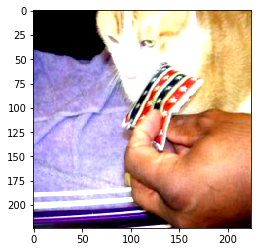

torch.Size([20, 3, 224, 224])
torch.Size([20])


In [8]:

# get some random training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
print(labels)
# show images
imshow(images)
print(images.shape)#Image Size is 224 X 224
print(labels.shape)


In [9]:
# CNN Model for Image Classification

In [10]:
import torch.nn as nn
import torch.nn.functional as F
class Net(nn.Module):
    def __init__(self):
        super(Net,self).__init__()
        #convo layer 1 (224,224,3)
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        
        #convo Layer 2 (112,112,16)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        
        #convo Layer 3 (56,56,32)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        
        #convo Layer 4(28,28,64)
        self.conv4 = nn.Conv2d(64, 128, 3, padding=1)
        
        #Maxpooling Layer
        self.pool = nn.MaxPool2d(2,2)
        
        #Linear Layer 128*14*14 --> 1024 
        self.fc1 = nn.Linear(128 * 14 * 14, 1024)
        
        #Linear Layer 1024 --> 512
        self.fc2 = nn.Linear(1024,512)
        
        #Linear Layer 512 --> 2
        self.fc3 = nn.Linear(512, 2)
        
        #Dropout to avoid overfitting
        self.dropout = nn.Dropout(0.3)
        
    def forward(self,x):
        
        x = self.pool(F.relu(self.conv1(x)))
        
        x = self.pool(F.relu(self.conv2(x)))
        
        x = self.pool(F.relu(self.conv3(x)))
        
        x = self.pool(F.relu(self.conv4(x)))
        
        x = x.view(-1, 128 * 14 * 14)
        
        x = self.dropout(x)
        
        x = F.relu(self.fc1(x))
        
        x = self.dropout(x)
        
        x = F.relu(self.fc2(x))
        
        x = self.dropout(x)
        
        x = F.relu(self.fc3(x))
        
        x = self.dropout(x)
        
        x = F.logsigmoid(x)
        
        return(x)
    
model = Net()
print(model)
        

Net(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=25088, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=2, bias=True)
  (dropout): Dropout(p=0.3)
)


In [11]:
import torch.optim as optim

# specify loss function (categorical cross-entropy)
criterion = nn.CrossEntropyLoss()

# specify optimizer
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [30]:
# number of epochs to train the model
n_epochs = 10

valid_loss_min = np.Inf # track change in validation loss

start_epoch = 0
filename = 'DC-Checkpoint.pt'
if os.path.isfile(filename):
        print("=> loading checkpoint '{}'".format(filename))
        checkpoint = torch.load(filename)
        start_epoch = checkpoint['epoch']
        model.load_state_dict(checkpoint['state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer'])
        loss = checkpoint['loss']
        print("=> loaded checkpoint '{}' (epoch {})"
                  .format(filename, checkpoint['epoch']))
                       



for epoch in range(1, n_epochs+1):

    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0
    start = time.time()
    ###################
    # train the model #
    ###################
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss
        train_loss += loss.item()*data.size(0)
        
    ######################    
    # validate the model #
    ######################
    model.eval()
    for batch_idx, (data, target) in enumerate(valid_loader):
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # update average validation loss 
        valid_loss += loss.item()*data.size(0)
    
    # calculate average losses
    train_loss = train_loss/len(train_loader.dataset)
    valid_loss = valid_loss/len(valid_loader.dataset)
        
    # print training/validation statistics 
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, valid_loss))
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save({'epoch':epoch,'model_state_dict':model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'loss': loss}, 'model_augmented.pt')
        valid_loss_min = valid_loss
    print(f" Time per Epoch: {(time.time() - start):.3f} seconds")

KeyboardInterrupt: 